<a href="https://colab.research.google.com/github/lyapunovExponentGood/Modeling-Time-Dependencies-In-Medical-Data/blob/main/SeizuresVs_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following code reads in the InterseizureInterval.csv data file, giving us a vector of interseizure intervals (ISIs). We partition the sample ISI time series into two segments that appear to be generated by fundamentally different functions, and consider only the first one. The code partitions the ISI data into training and test data (currently 75% of the data is used for training and 25% for testing). Here the our primary regressors are d-dimensional time delay embeddings of the ISIs, where each point is a vector of d consecutive ISIs. The network is trained to predict the (d+1)st ISI from this sequence of d ISIs.

The neural network used here is tensorflow's feedforward neural network. 

In [183]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math as mth

from tensorflow import keras
from keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [184]:
def disjointTimeEmbedding(array, d, n):
  m = mth.floor(n/(d+1)) #number of embeddings + correct one forecast into the future predictions 
  embeddings = np.zeros([m,d])
  answers = np.zeros([m,1])

  indx=0
  for i in range(0,m):
    embeddings[i,0:d] = array[0,indx:indx+d]
    #print('index: ',i)
    answers[i,0] = array[0,(indx+d)]
    indx = indx+d+1 #yields disjoint embeddings so that the values the nn is predicting do not show up in the input data 



  return[embeddings, answers, d, m]

In [185]:
#Generates surrogate datasets for H0: the null hypothesis of the data being independently and identically distributed
#Does do by permuting the indicies 
def Bootstrap(array,n): 
  #generate surrogate time series by uniformly scrambling the original time series
  #thus destroying any affect of temporal order 
  bootstraps = np.zeros((n, len(array)))
  for i in range (0,n):
    permute = np.random.permutation(array)
    bootstraps[i, 0:len(array)] = permute[0:len(array),0]

  return(bootstraps)

In [187]:
#the following code reads in the SortedInterSeizureInterval.csv file 
#ISIs are already parsed and sorted 
import csv

file = open('SortedInterSeizureInterval.csv')
csvreader = csv.reader(file)
ISI = np.zeros((2613, 1))

for i in range(0, 2613):
  nextRow = next(csvreader)
  ISI[i] = float(nextRow[0])

print(ISI)

[[ 2.91666667]
 [ 3.99305556]
 [ 2.98611111]
 ...
 [16.98055556]
 [19.        ]
 [17.96319444]]


In [188]:
#divide up sample time series
ISI1 = ISI[0:np.argmax(ISI)-1]
ISI2 = ISI[2345:len(ISI)]

#bootstraps for comparison
randomISI1 = Bootstrap(ISI1, 1) #scramble the time series to destroy any affect of temporal order
randomISI1 = np.transpose(randomISI1)

#we'll be predicting the first portion of the time series- the pre-brain surgery one
n = len(ISI1)
proportionTraining = 3/4 #This parameter sets what percentage of our data will be used to train the network

trainArray = np.zeros((1,mth.floor(n*proportionTraining)))
trainArray = np.transpose(ISI1[0:mth.floor(n*proportionTraining)]) 

print(trainArray)
print(ISI1)
#trainArray = np.transpose(trainArray)


[[2.91666667 3.99305556 2.98611111 ... 0.01041667 0.02083333 0.74652778]]
[[2.91666667]
 [3.99305556]
 [2.98611111]
 ...
 [0.01041667]
 [0.01041667]
 [0.01041667]]


In [189]:
[embeddingsX, answersX, dX, mX] = disjointTimeEmbedding(trainArray, 3, proportionTraining*n) #three dimensional embedding

In [190]:
print(embeddingsX)

[[2.91666667 3.99305556 2.98611111]
 [1.20138889 2.84027778 1.20833333]
 [0.5625     1.61458333 2.70833333]
 ...
 [0.00694444 0.73263889 0.03819444]
 [0.01041667 0.00694444 0.01388889]
 [0.00694444 0.01041667 0.02083333]]


In [191]:
#check that training embedding is correct
print(ISI[0:10])
print(answersX[0:10])

[[2.91666667]
 [3.99305556]
 [2.98611111]
 [1.83333333]
 [1.20138889]
 [2.84027778]
 [1.20833333]
 [0.77083333]
 [0.5625    ]
 [1.61458333]]
[[1.83333333e+00]
 [7.70833333e-01]
 [4.33333333e+00]
 [7.06250000e+00]
 [1.73611111e-02]
 [6.94444444e-03]
 [2.15625000e+00]
 [1.38888889e-02]
 [1.38888889e-02]
 [1.03125000e+00]]


In [192]:
testArray = np.transpose(ISI[mth.floor(proportionTraining*n):n])
[embeddingsTestX, answersTestX, dTest, mTestX] = disjointTimeEmbedding(testArray, 3, mth.floor(n-proportionTraining*n))

In [193]:
#Check that test embedding is correct
print(testArray[0,0:10])
print(answersTestX[0:10])

[0.01736111 0.01388889 0.01388889 0.01041667 0.14583333 0.01388889
 0.01041667 0.01736111 0.01388889 0.00694444]
[[0.01041667]
 [0.01736111]
 [0.        ]
 [0.01041667]
 [0.32291667]
 [0.01388889]
 [0.01388889]
 [0.02430556]
 [0.5       ]
 [0.00694444]]


In [194]:
#the purpose of the concatenate is to format the data when we have more than one vector of predictors
#not relevant now but this will be helpful when we start incorporating other regressors

inputs = np.concatenate([embeddingsX,], axis =1)
correctOutputs = np.concatenate([answersX,], axis=1)

inputsTest = np.concatenate([embeddingsTestX, ], axis = 1)
correctTestOutputs = np.concatenate([answersTestX, ], axis = 1)

In [195]:
np.shape(inputs)

(430, 3)

In [196]:
np.shape(inputsTest)

(143, 3)

In [197]:
tf.random.set_seed(7) # set random seek for the sake of consistency between tests 

In [199]:
#Svet's RNN: 
dimsIn =np.shape(inputs)
dimsOut =np.shape(correctOutputs)

rowsIn = dimsIn[0]
colsIn = dimsIn[1]

rowsOut = dimsOut[0]
colsOut = dimsOut[1]

#Note: Do NOT use the Keras embedding layer as this casts double inputs to integers-
#which throws away a LOT of information
#However, do store data in a tensor since that is the input format the RNN expects
inputTensor = np.zeros((rowsIn, colsIn, 1))
inputTensor[0:rowsIn, 0:colsIn, 0] = inputs

outputTensor = np.zeros((rowsOut, colsOut, 1))
outputTensor[0:rowsIn, 0:colsIn, 0] = correctOutputs

rnn = Sequential()

#rnn.add(Dropout(0.1)) #20% chance of an input being set to zero to regularize and prevent overfitting
#rnn.add(layers.SimpleRNN(units = 256, return_sequences=True))
rnn.add(layers.SimpleRNN(units = 128))
rnn.add(Dense(units = 64, activation = 'sigmoid', input_dim = 1))
rnn.add(Dense(units = 32, activation = 'sigmoid', input_dim = 1))
rnn.add(Dense(units = 16, activation = 'sigmoid', input_dim = 1))
rnn.add(Dense(units = 8, activation = 'sigmoid', input_dim = 1))
#rnn.add(Dense(units = 8, activation = 'sigmoid', input_dim = 1))
rnn.add(Dense(units = 1, activation = 'linear', input_dim = 1))  

In [ ]:
'''
#Jame's RNN: 
rnn = Sequential()

embedding = layers.Embedding(input_dim=1000, output_dim=64)
rnn.add(embedding)
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
rnn.add(layers.GRU(256, return_sequences=True))
# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
rnn.add(layers.SimpleRNN(128))
#rnn.add(layers.Dense(10))
rnn.add(layers.Dense(1))
'''

In [ ]:
'''
#FNN (for reference)
fnn = Sequential()

fnn.add(Dense(units = 3, activation = 'linear', input_shape=(3,)))
#fnn.add(Dense(units = 2048, activation = 'sigmoid', input_dim = 1))
#fnn.add(Dense(units = 1024, activation = 'sigmoid', input_dim = 1))
#fnn.add(Dense(units = 512, activation = 'sigmoid', input_dim = 1))
fnn.add(Dense(units = 256, activation = 'sigmoid', input_dim = 1))
fnn.add(Dense(units = 128, activation = 'sigmoid', input_dim = 1))
fnn.add(Dense(units = 64, activation = 'sigmoid', input_dim = 1))
fnn.add(Dense(units = 32, activation = 'sigmoid', input_dim = 1))
fnn.add(Dense(units = 16, activation = 'sigmoid', input_dim = 1))
fnn.add(Dense(units = 8, activation = 'sigmoid', input_dim = 1))
#fnn.add(Dense(units = 4, activation = 'sigmoid', input_dim = 1)) 
fnn.add(Dense(units = 1, activation = 'linear', input_dim = 1))  
'''

In [200]:
rnn.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
rnn.fit(inputTensor, correctOutputs, batch_size=8, epochs=1000)

Epoch 1/1000
54/54 [==============================] - 1s 3ms/step - loss: 1.0277
Epoch 2/1000
54/54 [==============================] - 0s 4ms/step - loss: 0.4926
Epoch 3/1000
54/54 [==============================] - 0s 3ms/step - loss: 0.4502
Epoch 4/1000
54/54 [==============================] - 0s 3ms/step - loss: 0.4458
Epoch 5/1000
54/54 [==============================] - 0s 3ms/step - loss: 0.4459
Epoch 6/1000
54/54 [==============================] - 0s 3ms/step - loss: 0.4477
Epoch 7/1000
54/54 [==============================] - 0s 3ms/step - loss: 0.4465
Epoch 8/1000
54/54 [==============================] - 0s 3ms/step - loss: 0.4460
Epoch 9/1000
54/54 [==============================] - 0s 3ms/step - loss: 0.4472
Epoch 10/1000
54/54 [==============================] - 0s 3ms/step - loss: 0.4448
Epoch 11/1000
54/54 [==============================] - 0s 3ms/step - loss: 0.4411
Epoch 12/1000
54/54 [==============================] - 0s 3ms/step - loss: 0.4297
Epoch 13/1000
54/54 [====

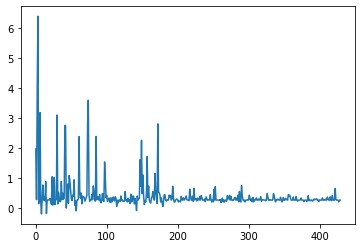

In [201]:
model = rnn.predict(inputs)
plt.plot(model)

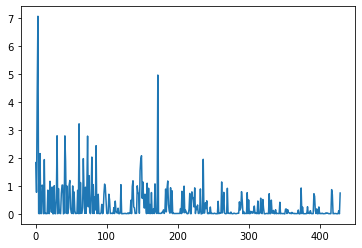

In [202]:
plt.plot(correctOutputs)

In [203]:
y_pred = rnn.predict(inputsTest)

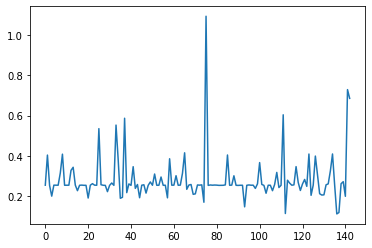

In [204]:
#print(y_pred)
plt.plot(y_pred)

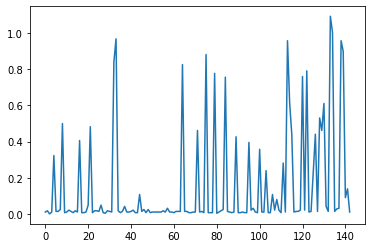

In [205]:
plt.plot(correctTestOutputs)

In [206]:
indxPred = np.argmax(y_pred)
print(indxPred)
#y_pred(0,indx)
print(correctTestOutputs[indxPred])
print(y_pred[indxPred])

indx = np.argmax(correctTestOutputs)
print(indx)
#y_pred(0,indx)
print(correctTestOutputs[indx])
print(y_pred[indx])

75
[0.88194444]
[1.0930784]
133
[1.09375]
[0.32563448]


In [207]:
#without correcting for degrees of freedom loss 
#because the test data is never used to estimate any parameters so no degrees of freedom lost

def MSE(predicted, actual):
  m = len(predicted)
  y_error = (1/(m)*np.sum(np.square(predicted - actual), axis=0))
  return y_error

In [208]:
y_error = MSE(y_pred, correctTestOutputs)
print(y_error)

[0.09084534]


In [ ]:
np.mean()

In [210]:
translated = y_pred - 0.2
transError = MSE(translated, correctTestOutputs)
print(transError)

[0.07615063]


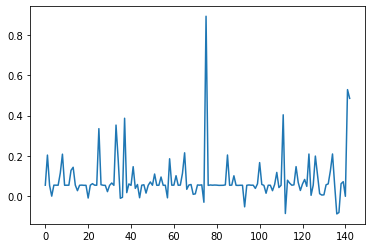

In [211]:
plt.plot(translated)